# Time Series Prediction with CNN and LSTM

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.0.0-rc1


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


## Creating dataset

In [3]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [4]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [5]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

## Training with dynamic learning rate

In [6]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

window_size = 30
train_set = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200)
])
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
with tf.device('/device:GPU:0'):
    history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/100
8/8 [==============================] - 9s 1s/step - loss: 73.2800 - mae: 73.6896
Epoch 2/100
8/8 [==============================] - 0s 22ms/step - loss: 72.6322 - mae: 72.9788
Epoch 3/100
8/8 [==============================] - 0s 20ms/step - loss: 71.4605 - mae: 71.8377
Epoch 4/100
8/8 [==============================] - 0s 21ms/step - loss: 70.0359 - mae: 70.4184
Epoch 5/100
8/8 [==============================] - 0s 21ms/step - loss: 68.2689 - mae: 68.7583
Epoch 6/100
8/8 [==============================] - 0s 20ms/step - loss: 66.4883 - mae: 66.8782
Epoch 7/100
8/8 [==============================] - 0s 24ms/step - loss: 64.2616 - mae: 64.7353
Epoch 8/100
8/8 [==============================] - 0s 28ms/step - loss: 62.0457 - mae: 62.3713
Epoch 9/100
8/8 [==============================] - 0s 25ms/step - loss: 59.3746 - mae: 59.7458
Epoch 10/100
8/8 [==============================] - 0

8/8 [==============================] - 0s 21ms/step - loss: 4.7175 - mae: 5.2023
Epoch 62/100
8/8 [==============================] - 0s 20ms/step - loss: 4.9295 - mae: 5.3703
Epoch 63/100
8/8 [==============================] - 0s 21ms/step - loss: 4.5738 - mae: 5.0649
Epoch 64/100
8/8 [==============================] - 0s 20ms/step - loss: 4.7221 - mae: 5.1539
Epoch 65/100
8/8 [==============================] - 0s 20ms/step - loss: 4.7139 - mae: 5.3121
Epoch 66/100
8/8 [==============================] - 0s 20ms/step - loss: 5.2634 - mae: 5.8696
Epoch 67/100
8/8 [==============================] - 0s 21ms/step - loss: 6.3169 - mae: 6.9606
Epoch 68/100
8/8 [==============================] - 0s 22ms/step - loss: 5.8850 - mae: 6.2913
Epoch 69/100
8/8 [==============================] - 0s 20ms/step - loss: 5.9062 - mae: 6.2902
Epoch 70/100
8/8 [==============================] - 0s 21ms/step - loss: 5.7395 - mae: 6.3387
Epoch 71/100
8/8 [==============================] - 0s 21ms/step - loss: 

## Result

[1e-08, 0.0001, 0, 30]

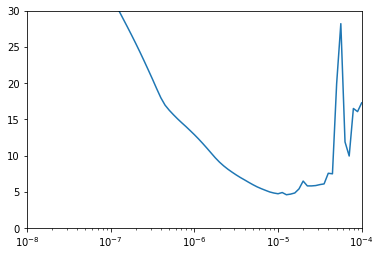

In [7]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

## Learning with fixed learning rate

In [8]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
#batch_size = 16
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200)
])

optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

with tf.device('/device:GPU:0'):
    history = model.fit(dataset,epochs=500)

Epoch 1/500
31/31 [==============================] - 3s 91ms/step - loss: 21.5713 - mae: 22.3311
Epoch 2/500
31/31 [==============================] - 0s 10ms/step - loss: 8.2302 - mae: 8.7146
Epoch 3/500
31/31 [==============================] - 0s 10ms/step - loss: 6.6356 - mae: 7.1109
Epoch 4/500
31/31 [==============================] - 0s 10ms/step - loss: 7.0235 - mae: 7.5119
Epoch 5/500
31/31 [==============================] - 0s 10ms/step - loss: 6.0404 - mae: 6.5162
Epoch 6/500
31/31 [==============================] - 0s 10ms/step - loss: 5.6468 - mae: 6.1226
Epoch 7/500
31/31 [==============================] - 0s 10ms/step - loss: 5.4648 - mae: 5.9431
Epoch 8/500
31/31 [==============================] - 0s 11ms/step - loss: 5.3224 - mae: 5.8035
Epoch 9/500
31/31 [==============================] - 0s 10ms/step - loss: 5.2586 - mae: 5.7316
Epoch 10/500
31/31 [==============================] - 0s 9ms/step - loss: 5.2180 - mae: 5.6945
Epoch 11/500
31/31 [============================

31/31 [==============================] - 0s 10ms/step - loss: 4.2744 - mae: 4.7543
Epoch 65/500
31/31 [==============================] - 0s 11ms/step - loss: 4.2512 - mae: 4.7261
Epoch 66/500
31/31 [==============================] - 0s 10ms/step - loss: 4.2650 - mae: 4.7492
Epoch 67/500
31/31 [==============================] - 0s 9ms/step - loss: 4.2522 - mae: 4.7238
Epoch 68/500
31/31 [==============================] - 0s 10ms/step - loss: 4.2498 - mae: 4.7234
Epoch 69/500
31/31 [==============================] - 0s 10ms/step - loss: 4.2475 - mae: 4.7179
Epoch 70/500
31/31 [==============================] - 0s 10ms/step - loss: 4.2168 - mae: 4.6902
Epoch 71/500
31/31 [==============================] - 0s 10ms/step - loss: 4.2470 - mae: 4.7191
Epoch 72/500
31/31 [==============================] - 0s 10ms/step - loss: 4.2291 - mae: 4.7041
Epoch 73/500
31/31 [==============================] - 0s 10ms/step - loss: 4.4165 - mae: 4.8910
Epoch 74/500
31/31 [==============================] - 

31/31 [==============================] - 0s 10ms/step - loss: 4.1196 - mae: 4.5926
Epoch 150/500
31/31 [==============================] - 0s 10ms/step - loss: 4.1994 - mae: 4.6765
Epoch 151/500
31/31 [==============================] - 0s 10ms/step - loss: 4.0774 - mae: 4.5526
Epoch 152/500
31/31 [==============================] - 0s 10ms/step - loss: 4.1041 - mae: 4.5769
Epoch 153/500
31/31 [==============================] - 0s 10ms/step - loss: 4.3575 - mae: 4.8356
Epoch 154/500
31/31 [==============================] - 0s 10ms/step - loss: 4.2726 - mae: 4.7461
Epoch 155/500
31/31 [==============================] - 0s 10ms/step - loss: 4.2346 - mae: 4.7049
Epoch 156/500
31/31 [==============================] - 0s 10ms/step - loss: 4.1289 - mae: 4.6017
Epoch 157/500
31/31 [==============================] - 0s 9ms/step - loss: 4.1622 - mae: 4.6348
Epoch 158/500
31/31 [==============================] - 0s 10ms/step - loss: 4.1268 - mae: 4.6015
Epoch 159/500
31/31 [========================

31/31 [==============================] - 0s 12ms/step - loss: 4.0578 - mae: 4.5297
Epoch 234/500
31/31 [==============================] - 0s 10ms/step - loss: 4.0789 - mae: 4.5508
Epoch 235/500
31/31 [==============================] - 0s 13ms/step - loss: 4.0928 - mae: 4.5659
Epoch 236/500
31/31 [==============================] - 0s 13ms/step - loss: 4.0892 - mae: 4.5587
Epoch 237/500
31/31 [==============================] - 0s 15ms/step - loss: 3.9916 - mae: 4.4680
Epoch 238/500
31/31 [==============================] - 0s 14ms/step - loss: 4.0115 - mae: 4.4818
Epoch 239/500
31/31 [==============================] - 0s 13ms/step - loss: 4.1648 - mae: 4.6426
Epoch 240/500
31/31 [==============================] - 0s 13ms/step - loss: 4.0922 - mae: 4.5664
Epoch 241/500
31/31 [==============================] - 0s 13ms/step - loss: 4.0894 - mae: 4.5633
Epoch 242/500
31/31 [==============================] - 0s 13ms/step - loss: 4.0959 - mae: 4.5699
Epoch 243/500
31/31 [=======================

31/31 [==============================] - 0s 11ms/step - loss: 3.9621 - mae: 4.4330
Epoch 318/500
31/31 [==============================] - 0s 11ms/step - loss: 3.9575 - mae: 4.4304
Epoch 319/500
31/31 [==============================] - 0s 10ms/step - loss: 4.0123 - mae: 4.4812
Epoch 320/500
31/31 [==============================] - 0s 9ms/step - loss: 3.9810 - mae: 4.4524
Epoch 321/500
31/31 [==============================] - 0s 10ms/step - loss: 4.0561 - mae: 4.5306
Epoch 322/500
31/31 [==============================] - 0s 10ms/step - loss: 4.0054 - mae: 4.4786
Epoch 323/500
31/31 [==============================] - 0s 12ms/step - loss: 3.9810 - mae: 4.4516
Epoch 324/500
31/31 [==============================] - 0s 10ms/step - loss: 3.9862 - mae: 4.4594
Epoch 325/500
31/31 [==============================] - 0s 10ms/step - loss: 3.9770 - mae: 4.4481
Epoch 326/500
31/31 [==============================] - 0s 10ms/step - loss: 3.9817 - mae: 4.4543
Epoch 327/500
31/31 [========================

31/31 [==============================] - 0s 11ms/step - loss: 3.9617 - mae: 4.4348
Epoch 402/500
31/31 [==============================] - 0s 11ms/step - loss: 3.9541 - mae: 4.4295
Epoch 403/500
31/31 [==============================] - 0s 10ms/step - loss: 3.9807 - mae: 4.4509
Epoch 404/500
31/31 [==============================] - 0s 9ms/step - loss: 3.9501 - mae: 4.4244
Epoch 405/500
31/31 [==============================] - 0s 11ms/step - loss: 3.9689 - mae: 4.4415
Epoch 406/500
31/31 [==============================] - 0s 10ms/step - loss: 4.0944 - mae: 4.5685
Epoch 407/500
31/31 [==============================] - 0s 10ms/step - loss: 3.9783 - mae: 4.4504
Epoch 408/500
31/31 [==============================] - 0s 10ms/step - loss: 3.9296 - mae: 4.4014
Epoch 409/500
31/31 [==============================] - 0s 11ms/step - loss: 3.9443 - mae: 4.4178
Epoch 410/500
31/31 [==============================] - 0s 9ms/step - loss: 3.9411 - mae: 4.4126
Epoch 411/500
31/31 [=========================

31/31 [==============================] - 0s 10ms/step - loss: 3.9122 - mae: 4.3804
Epoch 486/500
31/31 [==============================] - 0s 11ms/step - loss: 3.9350 - mae: 4.4073
Epoch 487/500
31/31 [==============================] - 0s 12ms/step - loss: 3.9654 - mae: 4.4409
Epoch 488/500
31/31 [==============================] - 0s 10ms/step - loss: 3.9314 - mae: 4.4048
Epoch 489/500
31/31 [==============================] - 0s 10ms/step - loss: 3.9147 - mae: 4.3852
Epoch 490/500
31/31 [==============================] - 0s 10ms/step - loss: 3.9831 - mae: 4.4579
Epoch 491/500
31/31 [==============================] - 0s 10ms/step - loss: 3.9579 - mae: 4.4319
Epoch 492/500
31/31 [==============================] - 0s 11ms/step - loss: 3.8963 - mae: 4.3699
Epoch 493/500
31/31 [==============================] - 0s 10ms/step - loss: 3.9225 - mae: 4.3937
Epoch 494/500
31/31 [==============================] - 0s 10ms/step - loss: 3.9024 - mae: 4.3744
Epoch 495/500
31/31 [=======================

## Results

In [9]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

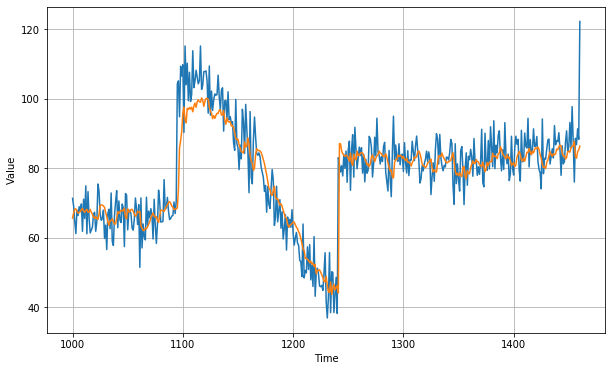

In [10]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [11]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

5.000942

<Figure size 432x288 with 0 Axes>

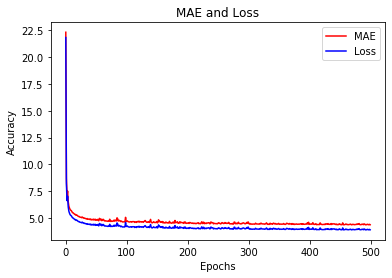

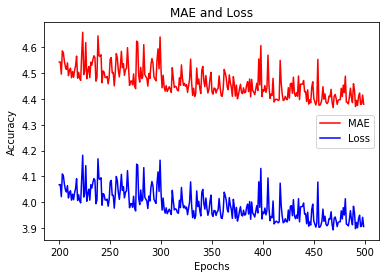

<Figure size 432x288 with 0 Axes>

In [12]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()